### San Francisco Housing Rental Analysis

In [7]:
# initial imports
import os
import pandas as pd
import matplotlib.pyplot as plt
import hvplot.pandas
import plotly.express as px
from pathlib import Path
from dotenv import load_dotenv

%matplotlib inline

In [8]:
# Read the Mapbox API key
load_dotenv()
mapbox_token = os.getenv("MAPBOX")

### Load Data

In [9]:
# Read the census data into a Pandas DataFrame
sfo_path = Path('~/Desktop/sfo.csv')
sfo_data = pd.read_csv(sfo_path, index_col="year")
sfo_data.head()

,neighborhood,sale_price_sqr_foot,housing_units,gross_rent
year,,,,
2010,Alamo Square,291.182945,372560,1239
2010,Anza Vista,267.932583,372560,1239
2010,Bayview,170.098665,372560,1239
2010,Buena Vista Park,347.394919,372560,1239
2010,Central Richmond,319.027623,372560,1239


### Housing Units Per Year

In [10]:
# Calculate the mean number of housing units per year
sfo_grp = sfo_data.groupby(sfo_data.index).mean()['housing_units']
sfo_grp

year
2010    372560
2011    374507
2012    376454
2013    378401
2014    380348
2015    382295
2016    384242
Name: housing_units, dtype: int64

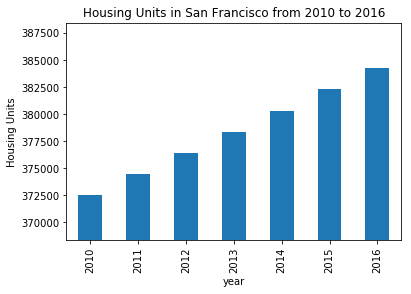

In [15]:
# Use the Pandas plot function to plot the average housing units per year.
# Note: You will need to manually adjust the y limit of the chart.

housing_min = sfo_grp.min()
housing_max = sfo_grp.max()
housing_std = sfo_grp.std()

fig_housing_units = plt.figure()
housing_units_plot = sfo_grp.plot.bar()
housing_units_plot.set_ylim(housing_min - housing_std, housing_max + housing_std)
housing_units_plot.set_title('Housing Units in San Francisco from 2010 to 2016')
housing_units_plot.set_ylabel('Housing Units')
plt.show()
plt.close(fig_housing_units)

### Average Prices per Square Foot

In [16]:
# Calculate the average gross rent and average sale price per square foot
sqft_avg = sfo_data.groupby(sfo_data.index).mean()['sale_price_sqr_foot']
gr_avg = sfo_data.groupby(sfo_data.index).mean()['gross_rent']
avg = pd.concat([sqft_avg, gr_avg], axis='columns', join='inner')
avg

,sale_price_sqr_foot,gross_rent
year,,
2010,369.344353,1239
2011,341.903429,1530
2012,399.389968,2324
2013,483.600304,2971
2014,556.277273,3528
2015,632.540352,3739
2016,697.643709,4390


### Average Gross Rent in San Francisco Per Year

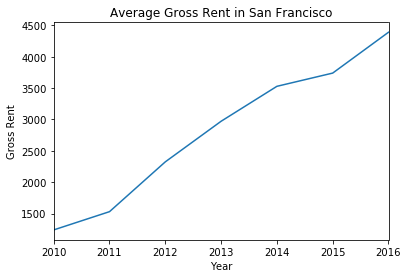

In [17]:
# Plot the Average Gross Rent per Year as a Line Chart 
gr_plt = gr_avg.plot(title= 'Average Gross Rent in San Francisco')
gr_plt.set_ylabel('Gross Rent')
gr_plt.set_xlabel('Year')

gr_plt

### Average Sales Price per Year

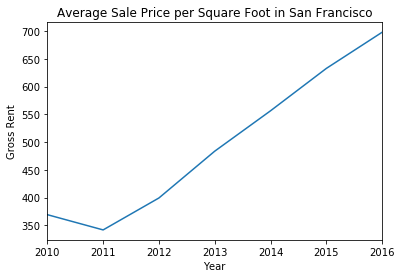

In [18]:
# Plot the Average Sales Price per Year as a line chart
sqft_plt = sqft_avg.plot(title= 'Average Sale Price per Square Foot in San Francisco')
sqft_plt.set_ylabel('Gross Rent')
sqft_plt.set_xlabel('Year')

sqft_plt

### Average Prices by Neighborhood

In [19]:
# Group by year and neighborhood and then create a new dataframe of the mean values
sfo_df = sfo_data.reset_index()
sfo_df.head()

,year,neighborhood,sale_price_sqr_foot,housing_units,gross_rent
0,2010,Alamo Square,291.182945,372560,1239
1,2010,Anza Vista,267.932583,372560,1239
2,2010,Bayview,170.098665,372560,1239
3,2010,Buena Vista Park,347.394919,372560,1239
4,2010,Central Richmond,319.027623,372560,1239


In [20]:
# Use hvplot to create an interactive line chart of the average price per sq ft.
# The plot should have a dropdown selector for the neighborhood
sfo_df_plot = sfo_df.hvplot.line(x='year', y='sale_price_sqr_foot', groupby = 'neighborhood')
sfo_df_plot

:DynamicMap   [neighborhood]
   :Curve   [year]   (sale_price_sqr_foot)

### The Top 10 Most Expensive Neighborhoods

In [22]:
# Find 10 most expensive neighborhoods
mtexn = sfo_data.groupby(by='neighborhood').mean()
mtexn = mtexn.nlargest(10, columns='sale_price_sqr_foot')
mtexn = mtexn.drop(columns= ['housing_units', 'gross_rent'])
mtexn

,sale_price_sqr_foot
neighborhood,
Union Square District,903.993258
Merced Heights,788.844818
Miraloma Park,779.810842
Pacific Heights,689.555817
Westwood Park,687.087575
Telegraph Hill,676.506578
Presidio Heights,675.350212
Cow Hollow,665.964042
Potrero Hill,662.013613


In [25]:
# Most expensive plot
mtexn_plot = mtexn.hvplot.bar(rot=90, yformatter='%.0f',
                              label='Most Expensive Neighborhoods in San Francisco', 
                              xlabel= 'Neighborhhod', ylabel='Average Price Per Sq Foot'
                            )
mtexn_plot

:Bars   [neighborhood]   (sale_price_sqr_foot)

### Parallel Coordinates and Parallel Categories Analysis

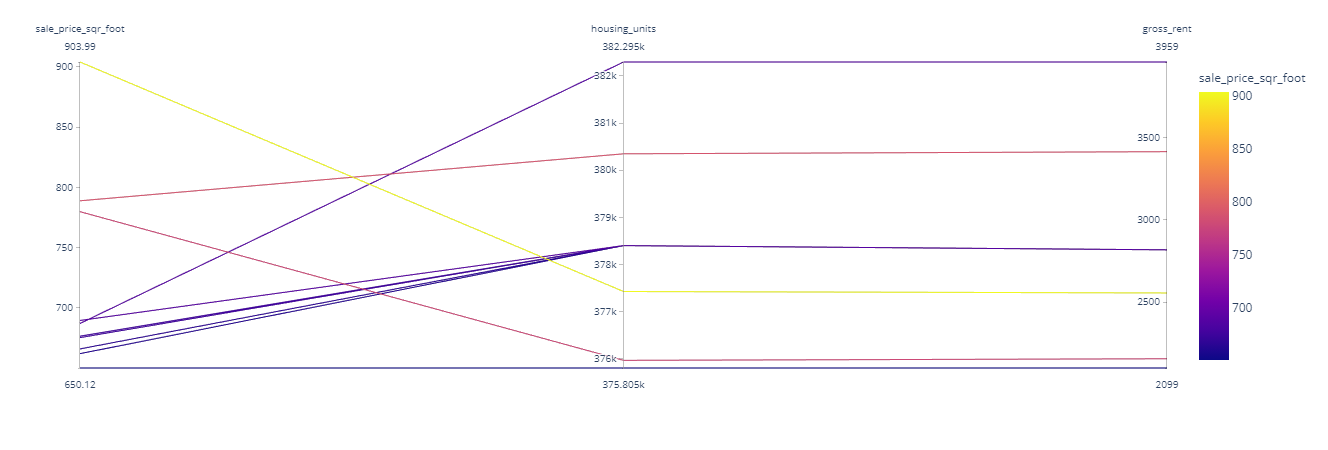

In [61]:
# Parallel Coordinates Plot
par_co = sfo_data.groupby('neighborhood').mean()
par_co = par_co.sort_values(by='sale_price_sqr_foot', ascending=False).head(10)
par_co = par_co.reset_index()
par_co_plot = px.parallel_coordinates(par_co, color='sale_price_sqr_foot')
par_co_plot

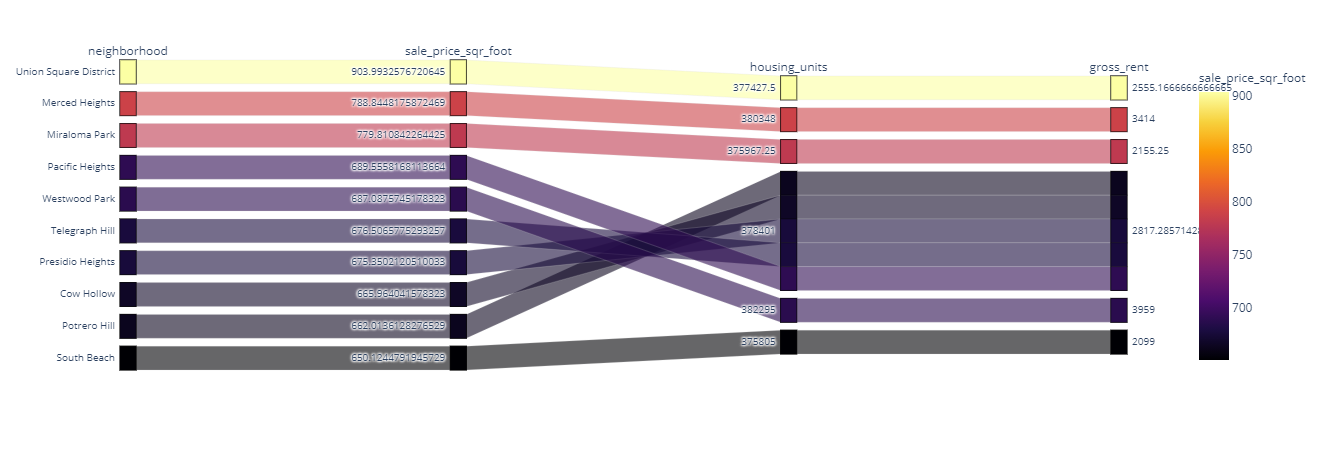

In [62]:
# Parallel Categories Plot
par_ca = sfo_data.groupby('neighborhood').mean()
par_ca = par_ca.sort_values(by="sale_price_sqr_foot", ascending=False).head(10)
par_ca = par_ca.reset_index()
par_ca_plot = px.parallel_categories(
    par_ca,
    dimensions=["neighborhood", "sale_price_sqr_foot", "housing_units", "gross_rent"],
    color="sale_price_sqr_foot",
    color_continuous_scale=px.colors.sequential.Inferno,
)
par_ca_plot

### Neighborhood Map

#### Load Location Data

In [32]:
# Load neighborhoods coordinates data
coord_path = Path("~/Desktop/ncoords.csv")
nbor = pd.read_csv(coord_path)
nbor.head()

,Neighborhood,Lat,Lon
0,Alamo Square,37.791012,-122.402100
1,Anza Vista,37.779598,-122.443451
2,Bayview,37.734670,-122.401060
3,Bayview Heights,37.728740,-122.410980
4,Bernal Heights,37.728630,-122.443050


### Data Preparation

In [33]:
# Calculate the mean values for each neighborhood
sfo_avg = sfo_df.groupby('neighborhood')['sale_price_sqr_foot', 'housing_units', 'gross_rent'].mean()
sfo_avg.head()

,sale_price_sqr_foot,housing_units,gross_rent
neighborhood,,,
Alamo Square,366.020712,378401.0,2817.285714
Anza Vista,373.382198,379050.0,3031.833333
Bayview,204.588623,376454.0,2318.400000
Bayview Heights,590.792839,382295.0,3739.000000
Bernal Heights,576.746488,379374.5,3080.333333


In [34]:
# Reset index
sfo_avg1 = sfo_avg.reset_index()
sfo_avg1.head()

,neighborhood,sale_price_sqr_foot,housing_units,gross_rent
0,Alamo Square,366.020712,378401.0,2817.285714
1,Anza Vista,373.382198,379050.0,3031.833333
2,Bayview,204.588623,376454.0,2318.400000
3,Bayview Heights,590.792839,382295.0,3739.000000
4,Bernal Heights,576.746488,379374.5,3080.333333


In [35]:
# Join the average values with the neighborhood locations
comb_df = pd.concat([nbor, sfo_avg1], axis=1, join='inner').drop(columns='neighborhood').round(2)
comb_df.head()

,Neighborhood,Lat,Lon,sale_price_sqr_foot,housing_units,gross_rent
0,Alamo Square,37.79,-122.40,366.02,378401.0,2817.29
1,Anza Vista,37.78,-122.44,373.38,379050.0,3031.83
2,Bayview,37.73,-122.40,204.59,376454.0,2318.40
3,Bayview Heights,37.73,-122.41,590.79,382295.0,3739.00
4,Bernal Heights,37.73,-122.44,576.75,379374.5,3080.33


### Mapbox Visualization

In [50]:
# Set the Mapbox API
px.set_mapbox_access_token(mapbox_token)

# Create a scatter mapbox to analyze neighborhood info
map = px.scatter_mapbox(
    comb_df,
    lat='Lat',
    lon='Lon',
    hover_name="Neighborhood", 
    hover_data=["sale_price_sqr_foot", "housing_units", "gross_rent"], 
    color='gross_rent',
    title='Average Sale Price Per Square Foot and Gross Rent in San Francisco',
    zoom=3)
map.show()

### San Francisco Rental Prices Dashboard

In [2]:
# initial imports
import os
import pandas as pd
import matplotlib.pyplot as plt
import hvplot.pandas
import panel as pn
from panel.interact import interact
import plotly.express as px
from pathlib import Path
from dotenv import load_dotenv

# Initialize the Panel Extensions (for Plotly)
pn.extension('plotly')

In [44]:
# Read the Mapbox API key
load_dotenv()
mapbox_token = os.getenv("MAPBOX")

### Import Data

### Panel Visualizations

In [ ]:
# Define Panel Visualization Functions
def housing_units_per_year():
    units = sfo_data
    fig_units = plt.figure()
    plot_fig_units = sfo_data['housing_units'].plot()
    plot_fig_units.set_xlabel('Year', fontsize=10)
    plot_fig_units.set_ylabel('Housing Units', fontsize=10)
    plot_fig_units.set_title('Housing Units Sold Per Year in San Francisco')
    plt.close(fig_units)
    return pn.pane.Matplotlib(fig_units, tight=True)
   

def average_gross_rent():
    avg_cost = (sfo_data[['sale_price_sqr_foot', 'gross_rent']].groupby(sfo_data.index).mean())
    
    fig_avg_gr = plt.figure()
    plot_fig_avg_gr = gr_avg.plot()
    plot_fig_avg_gr.set_xlabel('Year', fontsize=10)
    plot_fig_avg_gr.set_ylabel('Gross Rent', fontsize=10)
    plot_fig_avg_gr.set_title('Average Gross Rent Per Year in San Francisco', fontsize=12)
    plt.close(fig_avg_gr)
    return pn.pane.Matplotlib(fig_avg_gr, tight=True)
    
    
def average_sales_price():
    avg_cost = (sfo_data[['sale_price_sqr_foot', 'gross_rent']].groupby(sfo_data.index).mean())
    
    fig_avg_sp = plt.figure()
    plot_avg_sp = avg['sale_price_sqr_foot'].plot()
    plot_avg_sp.set_xlabel('Year', fontsize=10)
    plot_avg_sp.set_ylabel('Sales Price', fontsize=10)
    plot_avg_sp.set_title('Average Sales Price Per Year in San Francisco', fontsize=12)
    plt.close(fig_avg_sp)
    return pn.pane.Matplotlib(fig_avg_sp, tight=True)



def average_price_by_neighborhood():
    sfo_df_plot = sfo_df.hvplot.line(x='year', y='sale_price_sqr_foot', groupby = 'neighborhood')
    return sfo_df_plot

def top_most_expensive_neighborhoods():
    mtexn_plot = mtexn.hvplot.bar('sale_price_sqr_foot', label='Most Expensive Neighborhoods in San Francisco', xlabel='Neighborhood', bar_width=2, rot=90).opts(yformatter='%.0f')
    return mtexn_plot

def parallel_coordinates():
    par_co = px.parallel_coordinates(mtexn, color='sale_price_sqr_foot')
    
    return par_co


def parallel_categories():
    par_ca = px.parallel_categories(mtexn, color='sale_price_sqr_foot')
    
    return par_ca

def neighborhood_map():
    map = px.scatter_mapbox(
    comb_df,
    lat='Lat',
    lon='Lon',
    hover_name="Neighborhood", 
    hover_data=["sale_price_sqr_foot", "housing_units", "gross_rent"], 
    color='gross_rent',
    title='Average Sale Price Per Square Foot and Gross Rent in San Francisco',
    zoom=10)
    return map

SyntaxError: invalid syntax (<ipython-input-3-3303368c92ed>, line 5)

In [ ]:
# Create panel
welcome_col = pn.Column(
    "## Real Estate Analysis of San Francisco from 2010-2016",
            neighborhood_map(),)

yr_mkt_ays = pn.Column(
    housing_units_per_year(),
    average_gross_rent(),
    average_sales_price(),
)

nbor_col = pn.Column(
    average_price_by_neighborhood(),
    top_most_expensive_neighborhoods(),
)

par_plots_col = pn.Column(
    parallel_coordinates(),
    parallel_categories(),
)


dashboard = pn.Tabs(
    ("Welcome", welcome_col),
    ("Yearly Market Analysis", yr_mkt_ays ),
    ("Neighborhood Analysis", nbor_col ),
    ("Parallel Plots Analysis", par_plots_col )
)

dashboard.servable()